![header1](../figures/dc_2024_4dmedsea_banner.jpg) 

# Benchmark DUACS (all sat) Lagrangian Cumulative Distance
 

***
**Authors:**  CLS & Datlas <br>
**Copyright:** 2023 CLS & Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Benchmark of DUACS (all sat) geostrophic current trajectories</center></h1> 
</div>


<div class="alert alert-danger" role="alert">

<h3>Warning</h3>
 
<ul>
  DUACS is using all available satellites including the evaluation nadir.
</ul>
    
</div>

# 1. Import packages

In [1]:
import os
import numpy as np
import xarray as xr 
import matplotlib
import matplotlib.pylab as plt 
import matplotlib.ticker as mticker
import cmocean 
from scipy.interpolate import RegularGridInterpolator
import pickle
import gc
from matplotlib import cm 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import sys
sys.path.append('..')
from src.mod_plot import *
from src.mod_traj import *
from src.mod_compare import regional_zoom

# 2. Setup parameters

In [2]:
method_name = 'DUACS'

time_min = '2017-01-01'                                        # time min for analysis
time_max = '2017-12-31'                                        # time max for analysis

dir_out = f'../results/'                               # output directory path 
prefix_out = 'dict_drifter_adv'
results_out = 'deviat_uv_'+method_name+'.nc'

if not os.path.exists(dir_out):
    os.system('mkdir '+dir_out)

# Global
lon_min = -6                                          # domain min longitude
lon_max = 36                                          # domain max longitude
lat_min = 30.                                          # domain min latitude
lat_max = 46.                                          # domain max latitude 
 

# 3. Maps to evaluate

## 3.1 Download maps

In [3]:
path_maps =  f'../data/maps/DUACS_allsat/*.nc' 

maps = xr.open_mfdataset(path_maps)

maps = maps.sel({'longitude':slice(lon_min-0.5,lon_max+0.5)})
maps = maps.sel({'latitude':slice(lat_min-0.5,lat_max+0.5)})
maps

<xarray.Dataset>
Dimensions:         (time: 365, latitude: 136, nv: 2, longitude: 344)
Coordinates:
  * time            (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-12-31
  * latitude        (latitude) float32 29.56 29.69 29.81 ... 46.19 46.31 46.44
  * longitude       (longitude) float32 -6.438 -6.312 -6.188 ... 36.31 36.44
  * nv              (nv) int32 0 1
Data variables: (12/14)
    crs             (time) int32 -2147483647 -2147483647 ... -2147483647
    lat_bnds        (time, latitude, nv) float32 dask.array<chunksize=(1, 136, 2), meta=np.ndarray>
    lon_bnds        (time, longitude, nv) float32 dask.array<chunksize=(1, 344, 2), meta=np.ndarray>
    sla             (time, latitude, longitude) float64 dask.array<chunksize=(1, 136, 344), meta=np.ndarray>
    err_sla         (time, latitude, longitude) float64 dask.array<chunksize=(1, 136, 344), meta=np.ndarray>
    ugosa           (time, latitude, longitude) float64 dask.array<chunksize=(1, 136, 344), meta=np.ndarray>
    ...              ...
    err_vgosa       (time, latitude, longitude) float64 dask.array<chunksize=(1, 136, 344), meta=np.ndarray>
    adt             (time, latitude, longitude) float64 dask.array<chunksize=(1, 136, 344), meta=np.ndarray>
    ugos            (time, latitude, longitude) float64 dask.array<chunksize=(1, 136, 344), meta=np.ndarray>
    vgos            (time, latitude, longitude) float64 dask.array<chunksize=(1, 136, 344), meta=np.ndarray>
    flag_ice        (time, latitude, longitude) float64 dask.array<chunksize=(1, 136, 344), meta=np.ndarray>
    tpa_correction  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2017-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2016-12-31T12:00:00Z
    title:                           DT merged all satellites European Seas G...

## 3.2 Retrieve maps info 

In [4]:
time = maps.time.values
lon = maps.longitude.values
lat = maps.latitude.values 

time = (time.astype('datetime64[h]') - np.datetime64(time_min)).astype(int)
Nt = time[-1] 

u_maps = maps.ugos
v_maps = maps.vgos
 

# 4. Independant drifters

## 4.1 Download drifters

In [5]:
path_drifters = '../data/eval/indep_drifters/uv_drifters_*.nc'
ds_drifters = xr.open_mfdataset(path_drifters,concat_dim='time',combine='nested')
ds_drifters

<xarray.Dataset>
Dimensions:    (time: 12936)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-01 ... 2017-12-31
    latitude   (time) float32 dask.array<chunksize=(28,), meta=np.ndarray>
    longitude  (time) float32 dask.array<chunksize=(28,), meta=np.ndarray>
Data variables:
    EWCT       (time) float32 dask.array<chunksize=(28,), meta=np.ndarray>
    NSCT       (time) float32 dask.array<chunksize=(28,), meta=np.ndarray>
    sensor_id  (time) float64 dask.array<chunksize=(28,), meta=np.ndarray>
Attributes: (12/46)
    data_type:                   OceanSITES trajectory data
    format_version:              2.0
    platform_code:               10162380
    date_update:                 2020-10-13T12:09:42Z
    institution:                 AOML
    institution_edmo_code:       1799
    ...                          ...
    deployment_lat:              58.64
    last_longitude_observation:  53.59
    last_latitude_observation:   70.81
    date_drog_lost:              2013-07-28T17:00:00Z
    death_type:                  buoy ran aground
    last_date_observation:       2017-03-16T12:01:00Z

## 4.2 Prepare drifter data

In [6]:
%%time
ind, time_drifter, lon_drifter, lat_drifter, id_drifter= prepare_drifter_data(ds_drifters, maps, time_min, time_max)


CPU times: user 1min 55s, sys: 14.8 s, total: 2min 10s
Wall time: 2min 16s


# 5. Interpolate maps at drifters locations

In [7]:
%%time

# Create interpolation function
fu = RegularGridInterpolator((time, lat, lon), u_maps.values)
fv = RegularGridInterpolator((time, lat, lon), v_maps.values)

CPU times: user 11.1 s, sys: 2.76 s, total: 13.8 s
Wall time: 19.6 s


# 6. Artificial drifter trajectories 

## 6.1 Trajectory parameters and initialization 

In [8]:
nday = 5
dt_h = 24 
mode = 'euler' 
write = False 
Np = time_drifter.size

horizons = np.arange(0,nday*24/dt_h+1)

dict_drifter_adv_maps = {0:{'time':time_drifter,
                           'lon':lon_drifter,
                           'lat':lat_drifter,
                            'id':id_drifter}
                       }
horizons

array([0., 1., 2., 3., 4., 5.])

## 6.2 Compute trajectories

In [9]:
%%time
dict_drifter_adv_maps = compute_traj(dict_drifter_adv_maps, horizons, fu, fv ,Np, Nt, dt_h, method_name, dir_out, prefix_out, mode, write)


h 1.0
h 2.0.0
h 3.0.0
h 4.0.0
h 5.0.0
CPU times: user 20.6 s, sys: 348 ms, total: 21 s
Wall time: 23.9 s


# 7. Compute deviation  

In [10]:
# Deviation = Cumulative distance between artificial and real trajectories

# Average deviation by bins
lon_out=np.arange(lon_min, lon_max, 1)
lat_out=np.arange(lat_min, lat_max, 1)

horizon_days = [1,2,3,4,5]
    
dev_maps, var_dev_maps, dmean = compute_deviation(dict_drifter_adv_maps, Nt, dt_h, horizon_days,lon_out,lat_out, dir_out, method_name, results_out, overwrite =True)


# 8. Plots

## 8.1 Plot deviation maps at different horizons

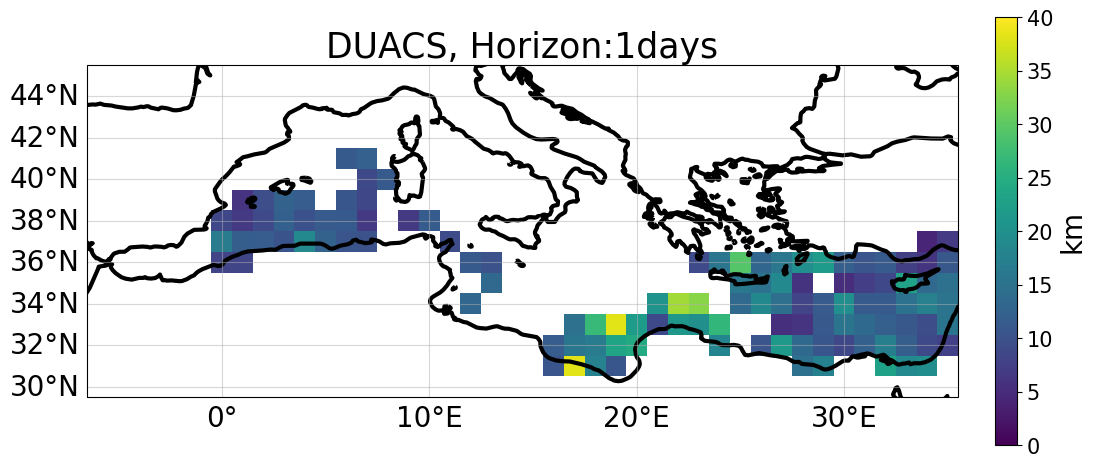

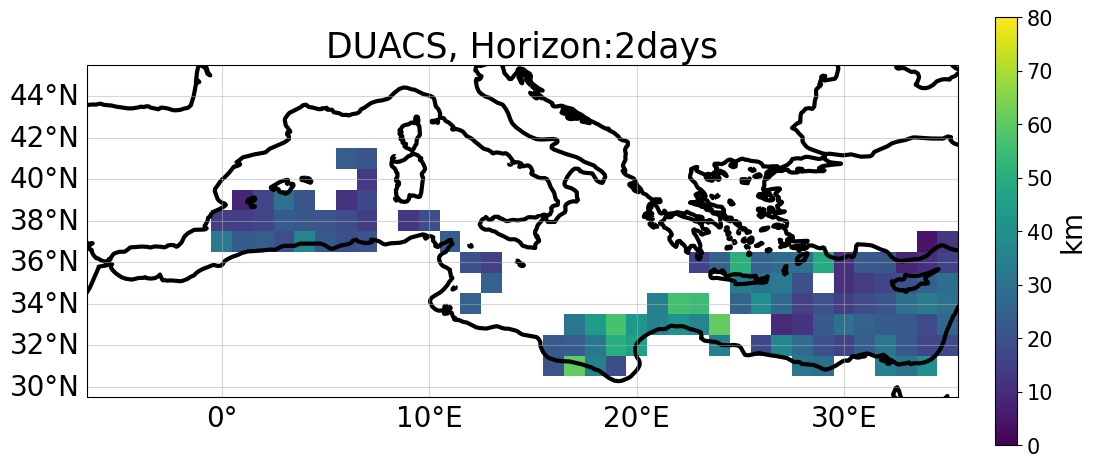

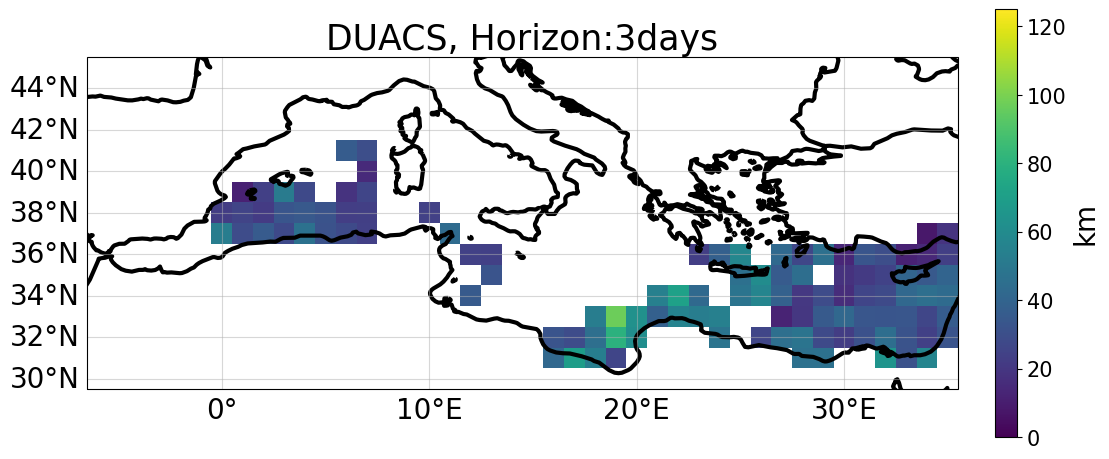

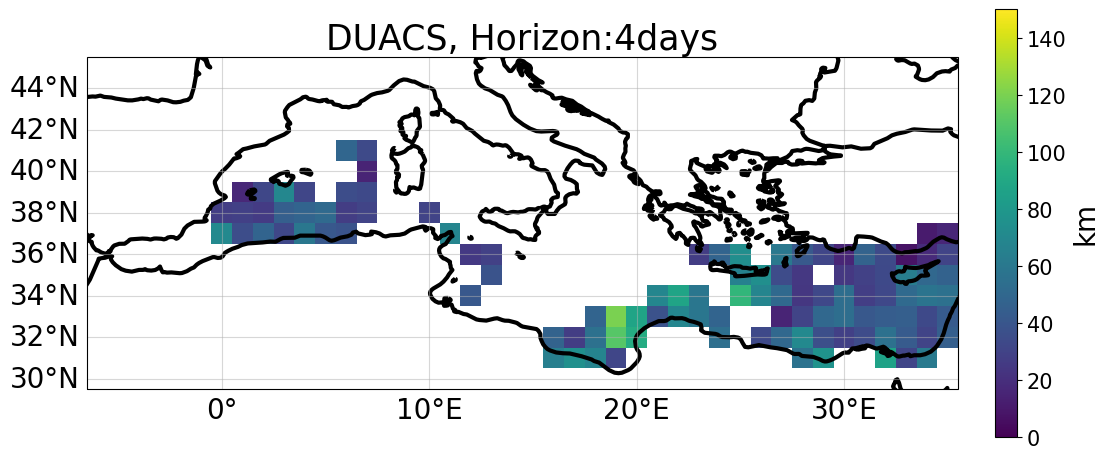

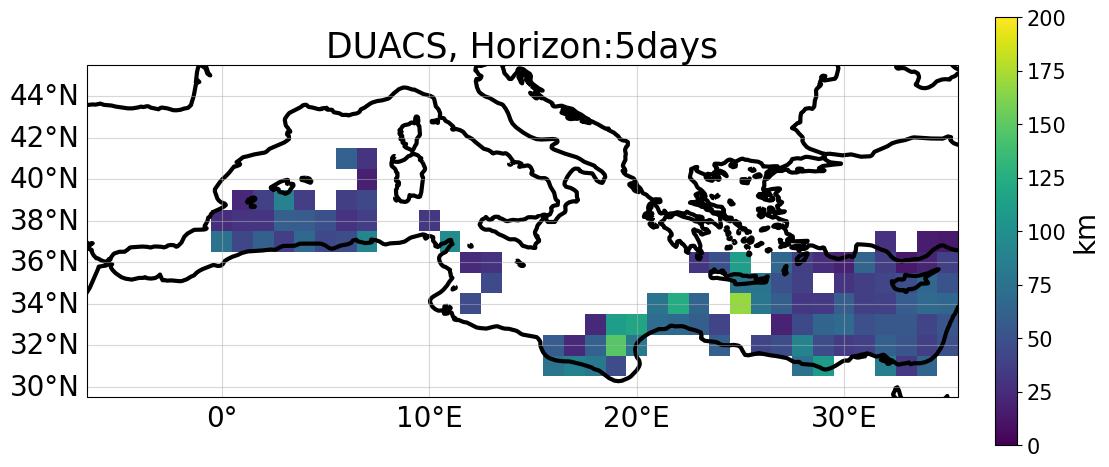

In [11]:
horizon_plots = [1,2,3,4,5]
horizon_plot_max = [40,80,125,150,200]

plot_traj_deviation_maps( lon_out, lat_out, dev_maps, dt_h,horizon_plots,horizon_plot_max,method_name) 


## 8.2 Plot spatially averaged deviation as a function of horizons

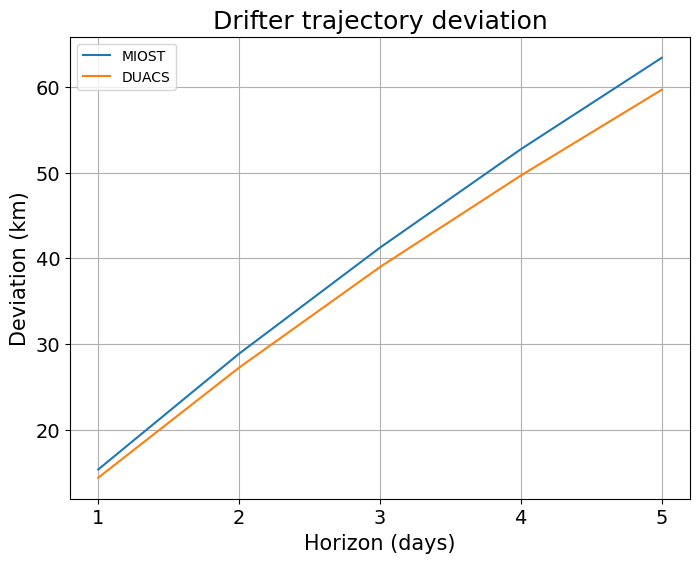

In [12]:
plot_meantraj_deviation(dir_out)